In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

## Question 1 Exploratory Data Analysis

* From example/input/ load compustat.csv inside compustat.zip without unzip compustat.zip

In [26]:
# read compustat.csv from compustat.zip
import zipfile
zf = zipfile.ZipFile("C:/Users/CDTchina/我的资源/Baruch/Python workshop 202007/session4/compustat.zip")
compustat = pd.read_csv(zf.open("compustat.csv"), header = 0)

print(compustat.shape)
compustat.head()

(1811299, 17)


,gvkey,datadate,fyearq,fqtr,indfmt,consol,popsrc,datafmt,cusip,curcdq,datacqtr,datafqtr,cshoq,saleq,costat,prccq,sic
0,1000,19660331,1966,1,INDL,C,D,STD,000032102,USD,1966Q1,1966Q1,0.219,NaN,I,NaN,3089.0
1,1000,19660630,1966,2,INDL,C,D,STD,000032102,USD,1966Q2,1966Q2,0.219,NaN,I,NaN,3089.0
2,1000,19660930,1966,3,INDL,C,D,STD,000032102,USD,1966Q3,1966Q3,0.219,NaN,I,NaN,3089.0
3,1000,19661231,1966,4,INDL,C,D,STD,000032102,USD,1966Q4,1966Q4,0.219,4.032,I,NaN,3089.0
4,1000,19670331,1967,1,INDL,C,D,STD,000032102,USD,1967Q1,1967Q1,0.277,NaN,I,NaN,3089.0


* Variable names that we are interested in:
    * sic code: four digits integer for company
    * datecqtr: year/ quarter time for the record
    * cusip: compustats identifier for a company
    * chod: shares out of standing (in million)
    * saleq: sales of current quarter (in million)
    * prccq: close price of current quarter (in dollar)

In [27]:
# select variables that we're interested in
my_compustat = compustat.loc[:,["sic","datacqtr","cusip","cshoq","saleq","prccq"]]
my_compustat['mktcap'] = my_compustat['cshoq'] * my_compustat['prccq'] 

print(my_compustat.shape)
my_compustat.head()

(1811299, 7)


,sic,datacqtr,cusip,cshoq,saleq,prccq,mktcap
0,3089.0,1966Q1,000032102,0.219,NaN,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN,NaN


* For saleq and market cap, compute the following:
    * Time series mean
    * Time Series standard deviation
    * Time Series count of missing values
    * Time Series ratio of missing values
    * Aggregate the result in a dataframe

In [28]:
def get_stats(df):
    mean = df.mean()
    std = df.std()
    size = df.shape[0]
    miss_count = size - df.count()
    miss_ratio = miss_count / size
    return pd.Series([mean, std, miss_count, miss_ratio], index = ['mean', 'std', 'miss_count', 'miss_ratio']).to_frame(name=df.name)

In [29]:
saleq_stats = get_stats(my_compustat['saleq'])
mktcap_stats = get_stats(my_compustat['mktcap'])
saleq_mktcap_stats = pd.concat([saleq_stats, mktcap_stats], axis = 1)
saleq_mktcap_stats.round(2)

,saleq,mktcap
mean,445.15,2057.47
std,2679.71,13202.20
miss_count,269498.00,468276.00
miss_ratio,0.15,0.26


* Answer the following questions:
    * Before computing any value, what kinds of descriptive analysis would you do to check if there are outliers?
    * Implement some schemes to detect outliers.

In [30]:
# get stats description for saleq / market cap
my_compustat[["saleq","mktcap"]].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
saleq,1541801.0,445.15,2679.71,-25623.0,3.21,21.82,130.53,207307.33
mktcap,1343023.0,2057.47,13202.20,0.0,20.01,94.22,525.71,1540774.21


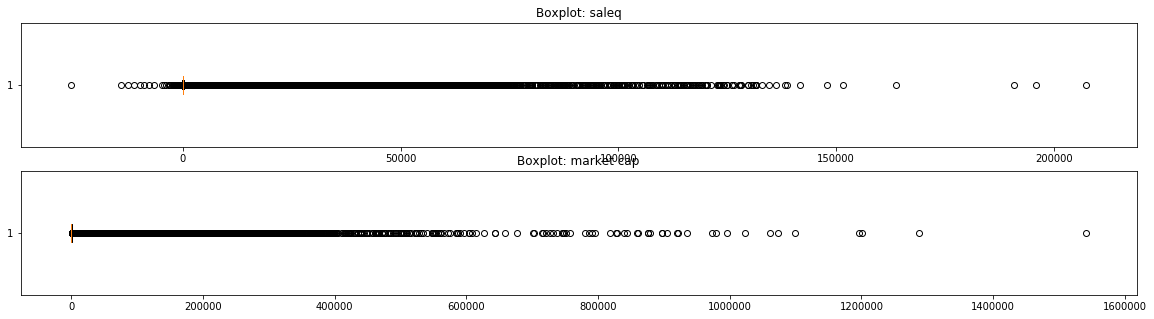

In [31]:
# boxplot for saleq / market cap
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(211)
plt.boxplot(my_compustat['saleq'].dropna(), vert = False)
plt.title("Boxplot: saleq")
plt.subplot(212)
plt.boxplot(my_compustat['mktcap'].dropna(), vert = False)
plt.title("Boxplot: market cap")
plt.show()

C:\Users\CDTchina\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\CDTchina\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


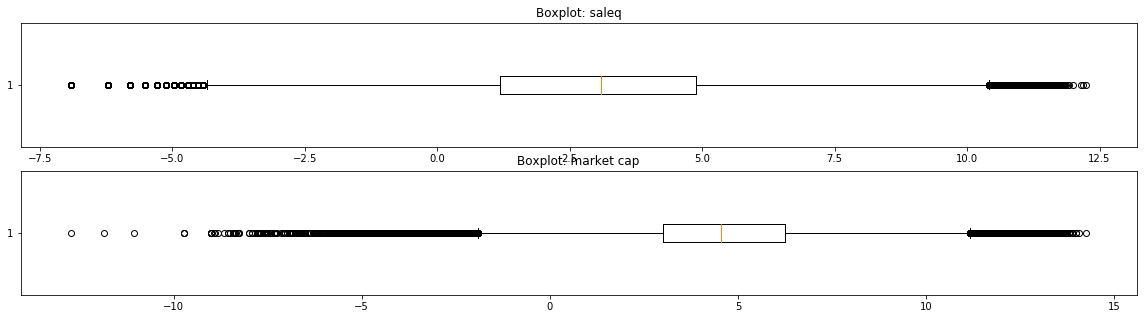

In [32]:
# Log outliers.
# We do logarithmic form because the distribution is heavily long-tailed, and financial data are usually distributed log-normally.
# Note that there are many negative saleq values, which would be dropped during computing log.
plt.figure(figsize=(20, 5))
plt.subplot(211)
plt.boxplot(np.log(my_compustat['saleq']).dropna(), vert = False)
plt.title("Boxplot: saleq")
plt.subplot(212)
plt.boxplot(np.log(my_compustat['mktcap']).dropna(), vert = False)
plt.title("Boxplot: market cap")
plt.show()

* Do you find some outliers? Could you think why? You can do some research using google.

* There are awfully many outliers.
* Reason:
    * We are testing here outliers whose values are over Q3+1.5IQR or under Q1－1.5IQR, which might not be a good choice for this scenario;
    * Companies(Industries) can vary a lot, and some companies(industries) can outperform others by a really large margin;
    * Both saleq and mkt_cap can shift violently during extreme periods, like financial crisis.

* What kinds of conclusion you can get from analyzing the table you get in 2? You can make some plots to illustrate.

Descriptive tables of the data suggest long right tail, as demonstrated by the boxplot.

Log boxplot, however, suggests that the data is not so long-tailed logarithmically, but still fat-tailed.

## Question 2 Compute Industry Concentration

The defination of HHI index could be found:

https://www.investopedia.com/terms/h/hhi.asp#:~:text=The%20Herfindahl%2DHirschman%20Index%20(HHI)%20is%20a%20commonly%20accepted,close%20to%20zero%20to%2010%2C000.

This index is used to measure the industry concentration and was used by congressman to determine whether to approve a merge deal or not.

Using the same data in question 1. Compute a panel data for HHI index for all industry, using a 2 digit SIC code.


In [51]:
my_compustat2 = my_compustat[['sic','datacqtr','mktcap']].dropna()
my_compustat2['industry'] = my_compustat2['sic'] // 100
my_compustat2['mktcap_ind'] = my_compustat2.groupby(['industry', 'datacqtr'])['mktcap'].transform('sum')

In [73]:
my_compustat2['mkt_share'] = my_compustat2['mktcap'] / my_compustat2['mktcap_ind'] * 100
my_compustat2['mkt_share2'] = my_compustat2['mkt_share'] ** 2
my_compustat2 = my_compustat2[['industry','datacqtr','mkt_share2']]

In [116]:
HHI_stat = my_compustat2.groupby(['industry','datacqtr']).sum().rename(columns={'mkt_share2':'HHI'})
HHI_stat.head()

HHI
industry datacqtr              
1.0      1967Q4    10000.000000
         1968Q1    10000.000000
         1968Q2     5667.833632
         1968Q3     5927.306594
         1968Q4     3414.368239

Choose top 4 industry with the highest average HHI index, plot their time series pattern of HHI in a 2 by 2 figure.

In [136]:
HHI_top4 = HHI_stat.groupby(['industry']).mean().sort_values(by = 'HHI', ascending = False)
HHI_top4 = HHI_top4[HHI_top4['HHI'] < 10000].head(4)
inds = [int(HHI_top4.index[i]) for i in range(4)]     # 4 chosen industries
inds

[81, 9, 84, 7]

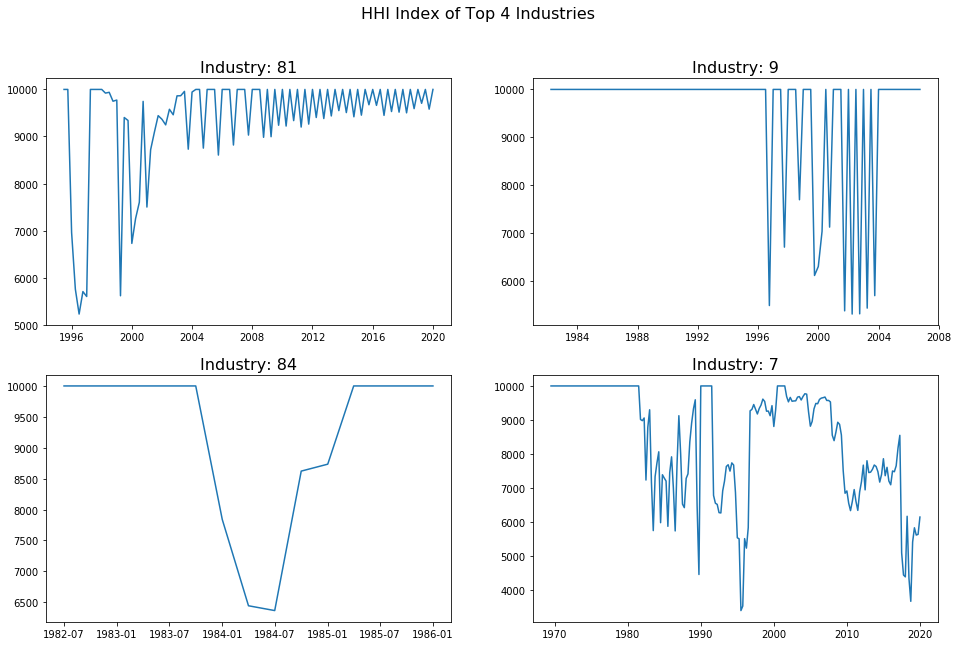

In [147]:
position = [(0,0),(0,1),(1,0),(1,1)]
fig = plt.figure(figsize=(16,10)) 
axes = fig.subplots(2,2)
fig.suptitle('HHI Index of Top 4 Industries', fontsize=16)
for i, ind in enumerate(inds):
    x = position[i][0]
    y = position[i][1]
    data = HHI_stat.loc[ind,:,:]
    t = pd.to_datetime(data.index.droplevel(level = 0))
    axes[x, y].plot(t, data['HHI'])
    axes[x, y].set_title(label='Industry: ' + str(ind), fontsize = 16)